In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, explode, when
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

import spacy
from spacy.matcher import PhraseMatcher
import pycountry
from collections import Counter
from pyspark.sql.types import ArrayType, StringType, DoubleType
import pyspark.sql.functions as F
from textblob import TextBlob
from geonamescache import GeonamesCache

In [8]:
# Creating the session with modified configuration
spark = SparkSession.builder \
    .config("spark.mongodb.read.connection.uri", "mongodb://127.0.0.1/data_engineering.preprocessed.coll") \
    .config("spark.mongodb.write.connection.uri", "mongodb://127.0.0.1/data_engineering.preprocessed.coll") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .config("spark.rdd.compress", "true") \
    .getOrCreate()

In [9]:
spark_df = spark.read.format("mongo") \
    .option("uri", "mongodb://127.0.0.1/data_engineering.preprocessed.coll") \
    .option("collection", "title_collection") \
    .load()

In [10]:
spark_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- preprocessed_title: string (nullable = true)



In [11]:
# show table
spark_df.select("preprocessed_title").show(n=5, truncate=False)

+------------------------------------------------------------+
|preprocessed_title                                          |
+------------------------------------------------------------+
|rent car insurance using bookingcom experience              |
|flying norway buenos aire one year old                      |
|help spain malaysia friend ’ diabetes pump broke get new one|
|tarom conflicting hand baggage allowance                    |
|night trip dublin recommendation                            |
+------------------------------------------------------------+
only showing top 5 rows



In [12]:
# get the number of rows
spark_df.select("preprocessed_title").count()

992

In [13]:
original_df = spark_df

In [14]:
NER_df = original_df

In [15]:
GEO_df = original_df

In [16]:
pycountry_df = original_df

In [17]:
normal_df = original_df

# NER

In [21]:
# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Function to extract countries using Named Entity Recognition (NER)
def extract_destination_NER(title):
    doc = nlp(title)
    return [ent.text for ent in doc.ents if ent.label_ == 'GPE']

In [22]:
# Define UDF to apply the function to each row in the DataFrame
extracted_countries_ner = udf(extract_destination_NER, ArrayType(StringType()))

In [23]:
# Apply the UDF to the 'title' column in the Spark DataFrame
NER_df = spark_df.withColumn('destinations', extracted_countries_ner(original_df['preprocessed_title']))

In [24]:
NER_df.show(n=5, truncate=False)

+--------------------------+------------------------------------------------------------+-----------------+
|_id                       |preprocessed_title                                          |destinations     |
+--------------------------+------------------------------------------------------------+-----------------+
|{662ca662a243ef41cf2752ef}|rent car insurance using bookingcom experience              |[]               |
|{662ca662a243ef41cf2752f0}|flying norway buenos aire one year old                      |[norway]         |
|{662ca662a243ef41cf2752f1}|help spain malaysia friend ’ diabetes pump broke get new one|[spain, malaysia]|
|{662ca662a243ef41cf2752f2}|tarom conflicting hand baggage allowance                    |[]               |
|{662ca662a243ef41cf2752f3}|night trip dublin recommendation                            |[]               |
+--------------------------+------------------------------------------------------------+-----------------+
only showing top 5 rows



In [25]:
NER_df.select("destinations").show(n=5, truncate=False)

+-----------------+
|destinations     |
+-----------------+
|[]               |
|[norway]         |
|[spain, malaysia]|
|[]               |
|[]               |
+-----------------+
only showing top 5 rows



In [26]:
from pyspark.sql.functions import explode, size, col
exploded_NER_df = NER_df.withColumn("destination", explode("destinations"))

In [27]:
filtered_NER_df = exploded_NER_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))

In [28]:
country_NER_counts = filtered_NER_df.groupBy("destination").count().orderBy("count", ascending=False)

In [29]:
country_NER_counts.show(truncate=False)

+-----------+-----+
|destination|count|
+-----------+-----+
|malaysia   |58   |
|canada     |27   |
|spain      |25   |
|italy      |22   |
|switzerland|14   |
|portugal   |13   |
|japan      |11   |
|paris      |10   |
|china      |10   |
|rome       |10   |
|vietnam    |10   |
|peru       |10   |
|new zealand|9    |
|taiwan     |9    |
|scotland   |8    |
|france     |7    |
|mexico     |7    |
|morocco    |6    |
|colombia   |6    |
|indonesia  |6    |
+-----------+-----+
only showing top 20 rows



Store in JSON

In [ ]:
# NER_json_df = NER_df.toPandas()

# NER_json_df.to_json('/home/hdlmf/sparksql/Code/data/NER_data_file1.json', orient='records', lines=True)

# Sentiment Analysis NER

In [ ]:
# pip install textblob

In [30]:
from textblob import TextBlob
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

# Define a function to analyze sentiment using TextBlob
def analyze_sentiment_textblob(title):
    analysis = TextBlob(title)
    return analysis.sentiment.polarity

# Register the UDF
analyze_sentiment_textblob_udf = F.udf(analyze_sentiment_textblob, DoubleType())

# Apply the sentiment analysis UDF to the preprocessed_title column
sentiment_df = NER_df.withColumn('title_sentiment', analyze_sentiment_textblob_udf(NER_df['preprocessed_title']))

# Show the DataFrame to check the content
sentiment_df.select('preprocessed_title', 'destinations', 'title_sentiment').show(truncate=False)

+-----------------------------------------------------------------+--------------------+-------------------+
|preprocessed_title                                               |destinations        |title_sentiment    |
+-----------------------------------------------------------------+--------------------+-------------------+
|rent car insurance using bookingcom experience                   |[]                  |0.0                |
|flying norway buenos aire one year old                           |[norway]            |0.1                |
|help spain malaysia friend ’ diabetes pump broke get new one     |[spain, malaysia]   |0.13636363636363635|
|tarom conflicting hand baggage allowance                         |[]                  |0.0                |
|night trip dublin recommendation                                 |[]                  |0.0                |
|possible visit switzerland italy austria croatia two week        |[switzerland, italy]|0.0                |
|bookingcom disastr

In [31]:
# Explode the destinations array to get one row per destination
exploded_df = sentiment_df.withColumn('destination', explode('destinations'))

In [32]:
from pyspark.sql.functions import col, explode, when

def count_sentiments(df):
    return df.groupBy('destination') \
             .agg(
                 F.sum(when(col('title_sentiment') > 0, 1).otherwise(0)).alias('positive'),
                 F.sum(when(col('title_sentiment') < 0, 1).otherwise(0)).alias('negative'),
                 F.sum(when(col('title_sentiment') == 0, 1).otherwise(0)).alias('neutral')
             )

# Calculate the count of sentiments for each destination
sentiment_counts_df = count_sentiments(exploded_df)

# Show the DataFrame to check the content
sentiment_counts_df.show(truncate=False)

+--------------------+--------+--------+-------+
|destination         |positive|negative|neutral|
+--------------------+--------+--------+-------+
|greece              |1       |0       |4      |
|australia           |2       |0       |0      |
|portugal            |2       |1       |10     |
|la san fran back day|0       |0       |1      |
|taipei              |1       |0       |1      |
|tokyo               |1       |1       |0      |
|san miguel germany  |1       |0       |0      |
|iraq                |0       |0       |1      |
|south africa blyde  |0       |1       |0      |
|poland              |1       |1       |1      |
|vienna              |0       |0       |2      |
|atlanta             |0       |1       |0      |
|south korea         |1       |0       |1      |
|austria             |0       |0       |1      |
|kazakhstan          |0       |0       |1      |
|nicaragua           |0       |0       |2      |
|kuwait              |0       |0       |1      |
|north carolina     

In [33]:
# Define a function to get the count of positive, negative, and neutral sentiments
def count_sentiments(df):
    return df.groupBy('destination') \
             .agg(
                 F.sum(when(col('title_sentiment') > 0, 1).otherwise(0)).alias('positive'),
                 F.sum(when(col('title_sentiment') < 0, 1).otherwise(0)).alias('negative'),
                 F.sum(when(col('title_sentiment') == 0, 1).otherwise(0)).alias('neutral'),
                 F.first('count').alias('title_count')
             ) \
             .orderBy('title_count', ascending=False)

In [34]:
# Calculate the count of titles for each destination
destination_counts_df = exploded_df.groupBy('destination').count()

# Join the destination counts with the sentiment analysis
joined_df = exploded_df.join(destination_counts_df, 'destination')

# Calculate the count of sentiments for each destination and sort by title count
sentiment_counts_df = count_sentiments(joined_df)

# Show the DataFrame to check the content
sentiment_counts_df.show(truncate=False)

+-----------+--------+--------+-------+-----------+
|destination|positive|negative|neutral|title_count|
+-----------+--------+--------+-------+-----------+
|malaysia   |14      |10      |34     |58         |
|canada     |9       |0       |18     |27         |
|spain      |4       |2       |19     |25         |
|italy      |2       |1       |19     |22         |
|switzerland|3       |1       |10     |14         |
|portugal   |2       |1       |10     |13         |
|japan      |2       |3       |6      |11         |
|paris      |2       |0       |8      |10         |
|china      |0       |0       |10     |10         |
|rome       |1       |1       |8      |10         |
|vietnam    |3       |0       |7      |10         |
|peru       |1       |1       |8      |10         |
|new zealand|9       |0       |0      |9          |
|taiwan     |3       |2       |4      |9          |
|scotland   |1       |0       |7      |8          |
|france     |0       |0       |7      |7          |
|mexico     

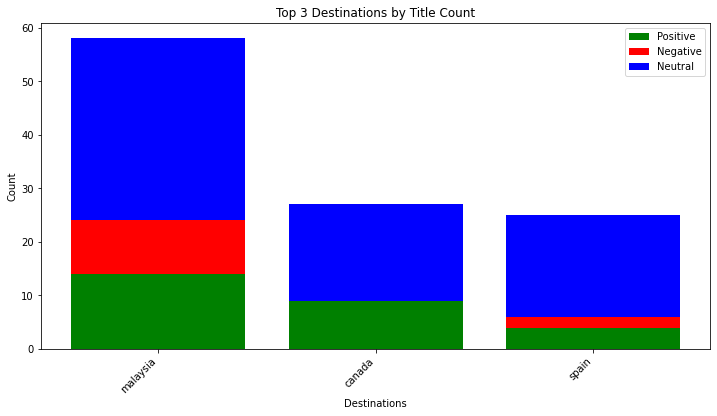

In [35]:
N = 3

# Sort the sentiment_counts_df by title_count in descending order and select the top N countries
top_countries = sentiment_counts_df.orderBy('title_count', ascending=False).limit(N)

# Convert the top_countries DataFrame to a Pandas DataFrame
top_countries_pd = top_countries.toPandas()

# Plot the sentiment counts for each country
plt.figure(figsize=(12, 6))
plt.bar(top_countries_pd['destination'], top_countries_pd['positive'], color='green', label='Positive')
plt.bar(top_countries_pd['destination'], top_countries_pd['negative'], color='red', label='Negative', bottom=top_countries_pd['positive'])
plt.bar(top_countries_pd['destination'], top_countries_pd['neutral'], color='blue', label='Neutral', bottom=top_countries_pd['positive']+top_countries_pd['negative'])
plt.xlabel('Destinations')
plt.ylabel('Count')
plt.title(f'Top {N} Destinations by Title Count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

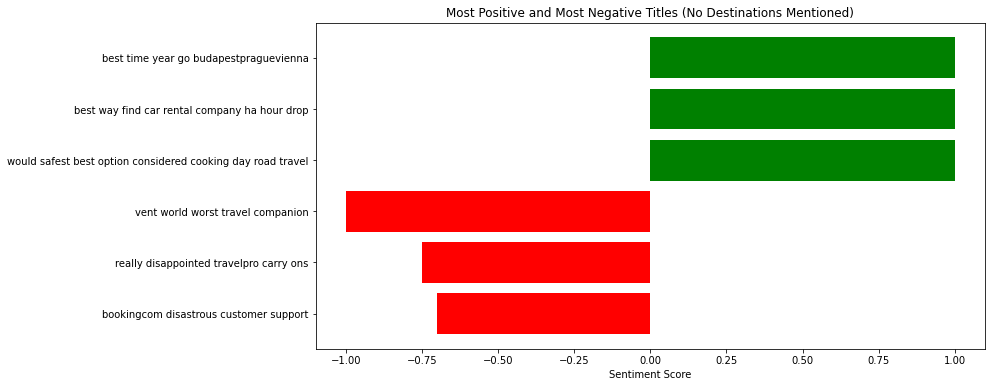

In [36]:
# N titles for most positive and most negative
N = 3

# Filter out titles that have destinations mentioned in them
filtered_titles = sentiment_df.filter(sentiment_df['destinations'].isNull() | (F.size(sentiment_df['destinations']) == 0))

# Get the most positive titles
most_positive_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=False) \
                                      .limit(N)

# Get the most negative titles
most_negative_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=True) \
                                      .limit(N)

# Concatenate the two DataFrames
top_titles = most_positive_titles.unionByName(most_negative_titles)

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
top_titles_pd = top_titles.toPandas()

# Plot the sentiment scores for the top titles
plt.figure(figsize=(12, 6))
plt.barh(range(2*N), top_titles_pd['title_sentiment'], color=['green']*N + ['red']*N)
plt.yticks(range(2*N), top_titles_pd['preprocessed_title'])
plt.xlabel('Sentiment Score')
plt.title('Most Positive and Most Negative Titles (No Destinations Mentioned)')
plt.gca().invert_yaxis()  # Reverse the order of the y-axis
plt.show()

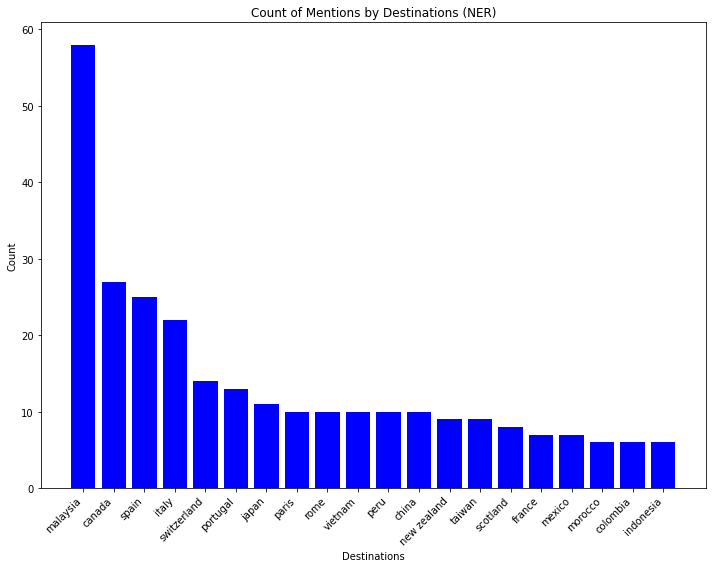

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

top20_NER_countries = country_NER_counts.orderBy(col("count").desc()).limit(20)
pandas_df = top20_NER_countries.toPandas()

# Now, plotting the data using matplotlib
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
plt.bar(pandas_df['destination'], pandas_df['count'], color='blue')  # Create a bar chart
plt.xlabel('Destinations')  # Label on X-axis
plt.ylabel('Count')  # Label on Y-axis
plt.title('Count of Mentions by Destinations (NER)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# GeonamesCache

In [78]:
# Load the spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Instantiate GeonamesCache
gc = GeonamesCache()

# Get a list of country names
countries = [country['name'] for country in gc.get_countries().values()]

# Function to extract countries from a given title
def extract_destination_GEO(title):
    # Convert the title to lowercase
    title = title.lower()
    
    # Initialize PhraseMatcher
    matcher = PhraseMatcher(nlp.vocab)
    
    # Add country names to the PhraseMatcher
    patterns = [nlp(country.lower()) for country in countries]
    matcher.add("COUNTRY", None, *patterns)
    
    # Process the title through spaCy to get entities
    doc = nlp(title)
    
    # List to store extracted countries
    extracted_countries = []
    
    # Iterate over matches
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        extracted_countries.append(span.text.capitalize())
    
    return extracted_countries

In [79]:
# Define UDF to apply the function to each row in the DataFrame
extracted_countries_GEO = udf(extract_destination_GEO, ArrayType(StringType()))

In [80]:
# Apply the UDF to the 'title' column in the Spark DataFrame
GEO_df = original_df.withColumn('destinations', extracted_countries_GEO(original_df['preprocessed_title']))

In [81]:
GEO_df.show(n=5, truncate=False)

+--------------------------+------------------------------------------------------------+-----------------+
|_id                       |preprocessed_title                                          |destinations     |
+--------------------------+------------------------------------------------------------+-----------------+
|{662ca662a243ef41cf2752ef}|rent car insurance using bookingcom experience              |[]               |
|{662ca662a243ef41cf2752f0}|flying norway buenos aire one year old                      |[Norway]         |
|{662ca662a243ef41cf2752f1}|help spain malaysia friend ’ diabetes pump broke get new one|[Spain, Malaysia]|
|{662ca662a243ef41cf2752f2}|tarom conflicting hand baggage allowance                    |[]               |
|{662ca662a243ef41cf2752f3}|night trip dublin recommendation                            |[]               |
+--------------------------+------------------------------------------------------------+-----------------+
only showing top 5 rows



In [82]:
GEO_df.select("destinations").show(n=5, truncate=False)

+-----------------+
|destinations     |
+-----------------+
|[]               |
|[Norway]         |
|[Spain, Malaysia]|
|[]               |
|[]               |
+-----------------+
only showing top 5 rows



In [83]:
exploded_GEO_df = GEO_df.withColumn("destination", explode("destinations"))

In [84]:
filtered_GEO_df = exploded_GEO_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))

In [85]:
country_GEO_counts = filtered_GEO_df.groupBy("destination").count().orderBy("count", ascending=False)

In [86]:
country_GEO_counts.show(n=20, truncate=False)

+-----------+-----+
|destination|count|
+-----------+-----+
|Malaysia   |63   |
|Canada     |43   |
|Italy      |26   |
|Spain      |25   |
|Switzerland|16   |
|Portugal   |15   |
|Peru       |14   |
|Mexico     |12   |
|Japan      |12   |
|Vietnam    |12   |
|France     |11   |
|Croatia    |11   |
|China      |10   |
|Taiwan     |9    |
|New zealand|9    |
|Germany    |8    |
|Greece     |8    |
|Austria    |8    |
|Thailand   |7    |
|Colombia   |7    |
+-----------+-----+
only showing top 20 rows



## Sentiment Analysis GEO (EXCLUDE)

In [ ]:
# Define a function to analyze sentiment using TextBlob
def analyze_sentiment_textblob(title):
    analysis = TextBlob(title)
    return analysis.sentiment.polarity

# Register the UDF
analyze_sentiment_textblob_udf = F.udf(analyze_sentiment_textblob, DoubleType())

# Apply the sentiment analysis UDF to the preprocessed_title column
sentiment_df = GEO_df.withColumn('title_sentiment', analyze_sentiment_textblob_udf(NER_df['preprocessed_title']))

# Show the DataFrame to check the content
sentiment_df.select('preprocessed_title', 'destinations', 'title_sentiment').show(truncate=False)

In [ ]:
# Explode the destinations array to get one row per destination
exploded_df = sentiment_df.withColumn('destination', explode('destinations'))

In [ ]:
from pyspark.sql.functions import col, explode, when

def count_sentiments(df):
    return df.groupBy('destination') \
             .agg(
                 F.sum(when(col('title_sentiment') > 0, 1).otherwise(0)).alias('positive'),
                 F.sum(when(col('title_sentiment') < 0, 1).otherwise(0)).alias('negative'),
                 F.sum(when(col('title_sentiment') == 0, 1).otherwise(0)).alias('neutral'),
                 F.first('count').alias('title_count')
             ) \
             .orderBy('title_count', ascending=False)

In [ ]:
# Calculate the count of titles for each destination
destination_counts_df = exploded_df.groupBy('destination').count()

# Join the destination counts with the sentiment analysis
joined_df = exploded_df.join(destination_counts_df, 'destination')

# Calculate the count of sentiments for each destination and sort by title count
sentiment_counts_df = count_sentiments(joined_df)

# Show the DataFrame to check the content
sentiment_counts_df.show(n = 20, truncate=False)

In [ ]:
N = 3

# Sort the sentiment_counts_df by title_count in descending order and select the top N countries
top_countries = sentiment_counts_df.orderBy('title_count', ascending=False).limit(N)

# Convert the top_countries DataFrame to a Pandas DataFrame
top_countries_pd = top_countries.toPandas()

# Plot the sentiment counts for each country
plt.figure(figsize=(12, 6))
plt.bar(top_countries_pd['destination'], top_countries_pd['positive'], color='green', label='Positive')
plt.bar(top_countries_pd['destination'], top_countries_pd['negative'], color='red', label='Negative', bottom=top_countries_pd['positive'])
plt.bar(top_countries_pd['destination'], top_countries_pd['neutral'], color='blue', label='Neutral', bottom=top_countries_pd['positive']+top_countries_pd['negative'])
plt.xlabel('Country')
plt.ylabel('Count')
plt.title(f'Top {N} Countries by Title Count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# N titles for most positive and most negative
N = 3

# Filter out titles that have destinations mentioned in them
filtered_titles = sentiment_df.filter(sentiment_df['destinations'].isNull() | (F.size(sentiment_df['destinations']) == 0))

# Get the most positive titles
most_positive_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=False) \
                                      .limit(N)

# Get the most negative titles
most_negative_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=True) \
                                      .limit(N)

# Concatenate the two DataFrames
top_titles = most_positive_titles.unionByName(most_negative_titles)

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
top_titles_pd = top_titles.toPandas()

# Plot the sentiment scores for the top titles
plt.figure(figsize=(12, 6))
plt.barh(range(2*N), top_titles_pd['title_sentiment'], color=['green']*N + ['red']*N)
plt.yticks(range(2*N), top_titles_pd['preprocessed_title'])
plt.xlabel('Sentiment Score')
plt.title('Most Positive and Most Negative Titles (No Destinations Mentioned)')
plt.gca().invert_yaxis()  # Reverse the order of the y-axis
plt.show()

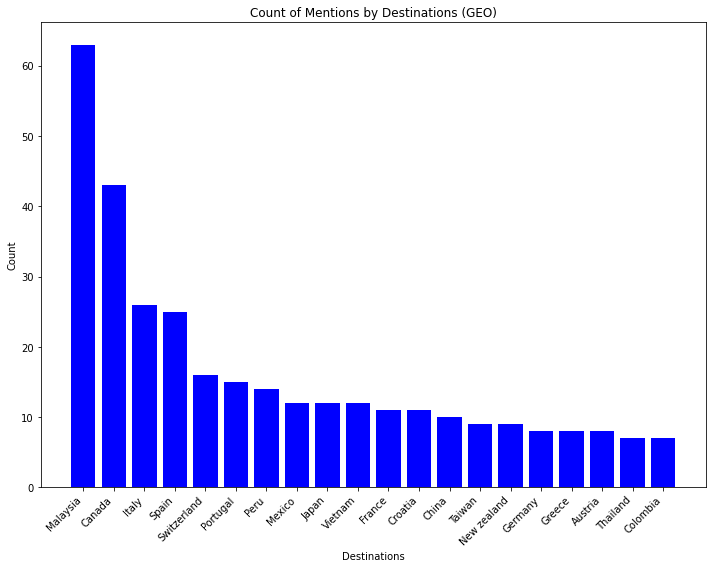

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# First, convert the Spark DataFrame to a Pandas DataFrame
# Ensure that your Spark environment has been configured to allow this conversion
top20_GEO_countries = country_GEO_counts.orderBy(col("count").desc()).limit(20)
pandas_df = top20_GEO_countries.toPandas()

# Now, plotting the data using matplotlib
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
plt.bar(pandas_df['destination'], pandas_df['count'], color='blue')  # Create a bar chart
plt.xlabel('Destinations')  # Label on X-axis
plt.ylabel('Count')  # Label on Y-axis
plt.title('Count of Mentions by Destinations (GEO)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Pycountry

In [ ]:
# pip install pycountry

In [40]:
def extract_destination_pycountry(text):
    countries = set()  # Use a set to avoid duplicates
    # Loop through all the countries in the pycountry database
    for country in pycountry.countries:
        # Check if the country's name is in the text
        if country.name.lower() in text:
            countries.add(country.name)
    return list(countries)  # Convert the set back to a list before returning it

In [41]:
extracted_destination_pycountry = udf(extract_destination_pycountry, ArrayType(StringType()))

In [42]:
pycountry_df = original_df.withColumn('destinations', extracted_destination_pycountry(original_df['preprocessed_title']))

In [43]:
pycountry_df.show(n=5, truncate=False)

+--------------------------+------------------------------------------------------------+-----------------+
|_id                       |preprocessed_title                                          |destinations     |
+--------------------------+------------------------------------------------------------+-----------------+
|{662ca662a243ef41cf2752ef}|rent car insurance using bookingcom experience              |[]               |
|{662ca662a243ef41cf2752f0}|flying norway buenos aire one year old                      |[Norway]         |
|{662ca662a243ef41cf2752f1}|help spain malaysia friend ’ diabetes pump broke get new one|[Spain, Malaysia]|
|{662ca662a243ef41cf2752f2}|tarom conflicting hand baggage allowance                    |[]               |
|{662ca662a243ef41cf2752f3}|night trip dublin recommendation                            |[]               |
+--------------------------+------------------------------------------------------------+-----------------+
only showing top 5 rows



In [44]:
exploded_pycountry_df = pycountry_df.withColumn("destination", explode("destinations"))

In [45]:
filtered_pycountry_df = exploded_pycountry_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))

In [46]:
country_pycountry_counts = filtered_pycountry_df.groupBy("destination").count().orderBy("count", ascending=False)

In [47]:
country_pycountry_counts.show(n=20, truncate=False)

+-----------+-----+
|destination|count|
+-----------+-----+
|Malaysia   |57   |
|Canada     |43   |
|Italy      |28   |
|Spain      |26   |
|Portugal   |18   |
|Switzerland|17   |
|Peru       |13   |
|Croatia    |13   |
|Mexico     |13   |
|Japan      |13   |
|France     |11   |
|India      |11   |
|China      |10   |
|New Zealand|9    |
|Germany    |8    |
|Greece     |8    |
|Morocco    |8    |
|Austria    |8    |
|Colombia   |7    |
|Ireland    |6    |
+-----------+-----+
only showing top 20 rows



## Sentiment Analysis Pycountry

In [48]:
# Define a function to analyze sentiment using TextBlob
def analyze_sentiment_textblob(title):
    analysis = TextBlob(title)
    return analysis.sentiment.polarity

# Register the UDF
analyze_sentiment_textblob_udf = F.udf(analyze_sentiment_textblob, DoubleType())

# Apply the sentiment analysis UDF to the preprocessed_title column
sentiment_df = pycountry_df.withColumn('title_sentiment', analyze_sentiment_textblob_udf(NER_df['preprocessed_title']))

# Show the DataFrame to check the content
sentiment_df.select('preprocessed_title', 'destinations', 'title_sentiment').show(truncate=False)

+-----------------------------------------------------------------+--------------------------------------+-------------------+
|preprocessed_title                                               |destinations                          |title_sentiment    |
+-----------------------------------------------------------------+--------------------------------------+-------------------+
|rent car insurance using bookingcom experience                   |[]                                    |0.0                |
|flying norway buenos aire one year old                           |[Norway]                              |0.1                |
|help spain malaysia friend ’ diabetes pump broke get new one     |[Spain, Malaysia]                     |0.13636363636363635|
|tarom conflicting hand baggage allowance                         |[]                                    |0.0                |
|night trip dublin recommendation                                 |[]                                    |0.0  

In [49]:
# Explode the destinations array to get one row per destination
exploded_df = sentiment_df.withColumn('destination', explode('destinations'))

In [50]:
# Define a function to get the count of positive, negative, and neutral sentiments
def count_sentiments(df):
    return df.groupBy('destination') \
             .agg(
                 F.sum(when(col('title_sentiment') > 0, 1).otherwise(0)).alias('positive'),
                 F.sum(when(col('title_sentiment') < 0, 1).otherwise(0)).alias('negative'),
                 F.sum(when(col('title_sentiment') == 0, 1).otherwise(0)).alias('neutral'),
                 F.first('count').alias('title_count')
             ) \
             .orderBy('title_count', ascending=False)

In [52]:
# Calculate the count of titles for each destination
destination_counts_df = exploded_df.groupBy('destination').count()

# Join the destination counts with the sentiment analysis
joined_df = exploded_df.join(destination_counts_df, 'destination')

# Calculate the count of sentiments for each destination and sort by title count
sentiment_counts_df = count_sentiments(joined_df)

# Show the DataFrame to check the content
sentiment_counts_df.show(truncate=False)

+-----------+--------+--------+-------+-----------+
|destination|positive|negative|neutral|title_count|
+-----------+--------+--------+-------+-----------+
|Malaysia   |14      |9       |34     |57         |
|Canada     |14      |5       |24     |43         |
|Italy      |3       |3       |22     |28         |
|Spain      |3       |2       |21     |26         |
|Portugal   |2       |1       |15     |18         |
|Switzerland|3       |2       |12     |17         |
|Peru       |3       |1       |9      |13         |
|Croatia    |2       |4       |7      |13         |
|Mexico     |5       |2       |6      |13         |
|Japan      |2       |3       |8      |13         |
|France     |1       |0       |10     |11         |
|India      |0       |0       |11     |11         |
|China      |0       |0       |10     |10         |
|New Zealand|9       |0       |0      |9          |
|Germany    |2       |0       |6      |8          |
|Greece     |1       |0       |7      |8          |
|Morocco    

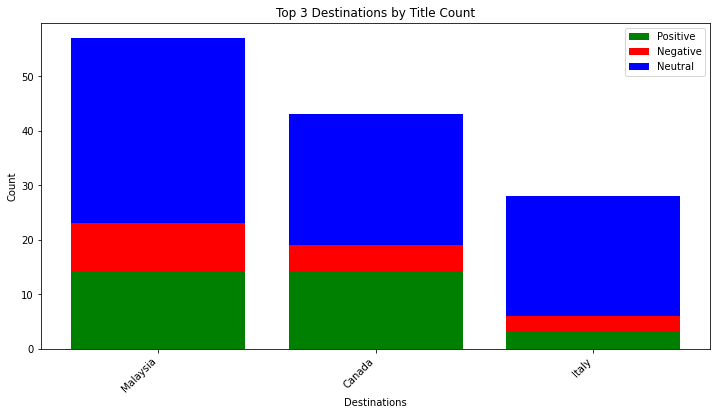

In [54]:
N = 3

# Sort the sentiment_counts_df by title_count in descending order and select the top N countries
top_countries = sentiment_counts_df.orderBy('title_count', ascending=False).limit(N)

# Convert the top_countries DataFrame to a Pandas DataFrame
top_countries_pd = top_countries.toPandas()

# Plot the sentiment counts for each country
plt.figure(figsize=(12, 6))
plt.bar(top_countries_pd['destination'], top_countries_pd['positive'], color='green', label='Positive')
plt.bar(top_countries_pd['destination'], top_countries_pd['negative'], color='red', label='Negative', bottom=top_countries_pd['positive'])
plt.bar(top_countries_pd['destination'], top_countries_pd['neutral'], color='blue', label='Neutral', bottom=top_countries_pd['positive']+top_countries_pd['negative'])
plt.xlabel('Destinations')
plt.ylabel('Count')
plt.title(f'Top {N} Destinations by Title Count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

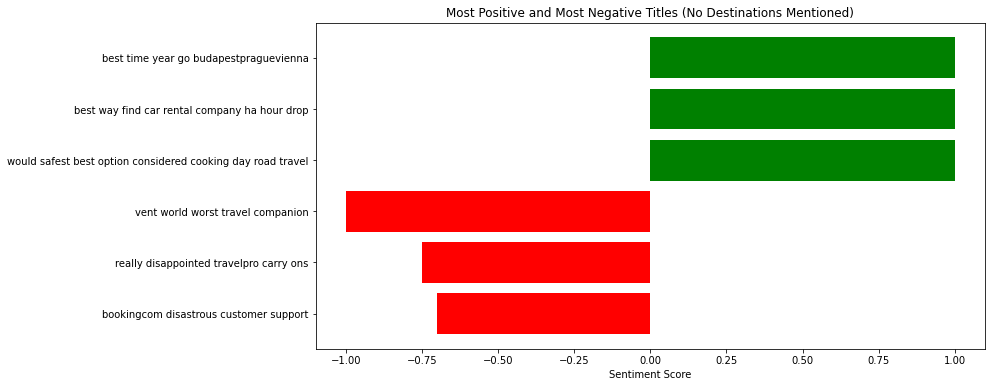

In [55]:
# N titles for most positive and most negative
N = 3

# Filter out titles that have destinations mentioned in them
filtered_titles = sentiment_df.filter(sentiment_df['destinations'].isNull() | (F.size(sentiment_df['destinations']) == 0))

# Get the most positive titles
most_positive_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=False) \
                                      .limit(N)

# Get the most negative titles
most_negative_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=True) \
                                      .limit(N)

# Concatenate the two DataFrames
top_titles = most_positive_titles.unionByName(most_negative_titles)

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
top_titles_pd = top_titles.toPandas()

# Plot the sentiment scores for the top titles
plt.figure(figsize=(12, 6))
plt.barh(range(2*N), top_titles_pd['title_sentiment'], color=['green']*N + ['red']*N)
plt.yticks(range(2*N), top_titles_pd['preprocessed_title'])
plt.xlabel('Sentiment Score')
plt.title('Most Positive and Most Negative Titles (No Destinations Mentioned)')
plt.gca().invert_yaxis()  # Reverse the order of the y-axis
plt.show()

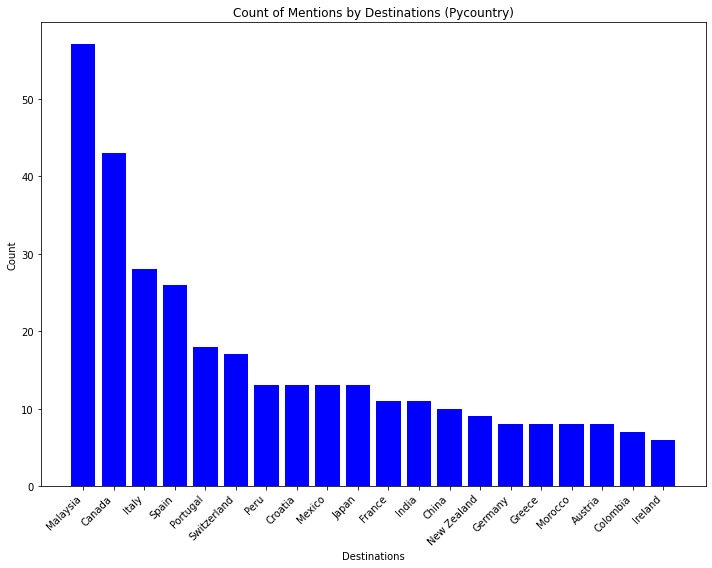

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# First, convert the Spark DataFrame to a Pandas DataFrame
# Ensure that your Spark environment has been configured to allow this conversion
top20_pycountry_countries = country_pycountry_counts.orderBy(col("count").desc()).limit(20)
pandas_df = top20_pycountry_countries.toPandas()

# Now, plotting the data using matplotlib
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
plt.bar(pandas_df['destination'], pandas_df['count'], color='blue')  # Create a bar chart
plt.xlabel('Destinations')  # Label on X-axis
plt.ylabel('Count')  # Label on Y-axis
plt.title('Count of Mentions by Destinations (Pycountry)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Normal Extraction

In [57]:
def extract_destination(text):
    # Define a simple list of country names
    countries_list = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola",
        "Antigua and Barbuda", "Argentina", "Armenia", "Australia",
        "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh",
        "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil",
        "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Côte d'Ivoire",
        "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic",
        "Chad", "Chile", "China", "Colombia", "Comoros", "Congo (Congo-Brazzaville)",
        "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czechia (Czech Republic)",
        "Democratic Republic of the Congo", "Denmark", "Djibouti", "Dominica",
        "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea",
        "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji",
        "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana",
        "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Holy See", "Honduras", "Hungary", "Iceland", "India", "Indonesia",
        "Iran", "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia",
        "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali",
        "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico",
        "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco",
        "Mozambique", "Myanmar (formerly Burma)", "Namibia", "Nauru", "Nepal",
        "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Korea",
        "North Macedonia (formerly Macedonia)", "Norway", "Oman", "Pakistan",
        "Palau", "Palestine State", "Panama", "Papua New Guinea", "Paraguay",
        "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia",
        "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines",
        "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal",
        "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia",
        "Solomon Islands", "Somalia", "South Africa", "South Korea", "South Sudan",
        "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Tajikistan", "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga",
        "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu",
        "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States",
        "Uruguay", "Uzbekistan", "Vanuatu", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    found_countries = []
    # Check each country in the list to see if it appears in the text
    for country in countries_list:
        if country.lower() in text:
            found_countries.append(country)
    return found_countries

In [58]:
extracted_destination = udf(extract_destination, ArrayType(StringType()))

In [59]:
normal_df = original_df.withColumn('destinations', extracted_destination(original_df['preprocessed_title']))

In [60]:
normal_df.show(n=5, truncate=False)

+--------------------------+------------------------------------------------------------+-----------------+
|_id                       |preprocessed_title                                          |destinations     |
+--------------------------+------------------------------------------------------------+-----------------+
|{662ca662a243ef41cf2752ef}|rent car insurance using bookingcom experience              |[]               |
|{662ca662a243ef41cf2752f0}|flying norway buenos aire one year old                      |[Norway]         |
|{662ca662a243ef41cf2752f1}|help spain malaysia friend ’ diabetes pump broke get new one|[Malaysia, Spain]|
|{662ca662a243ef41cf2752f2}|tarom conflicting hand baggage allowance                    |[]               |
|{662ca662a243ef41cf2752f3}|night trip dublin recommendation                            |[]               |
+--------------------------+------------------------------------------------------------+-----------------+
only showing top 5 rows



In [61]:
exploded_normal_df = normal_df.withColumn("destination", explode("destinations"))

In [62]:
filtered_normal_df = exploded_normal_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))

In [63]:
country_normal_counts = filtered_normal_df.groupBy("destination").count().orderBy("count", ascending=False)

In [64]:
country_normal_counts.show(n=20, truncate=False)

+-----------+-----+
|destination|count|
+-----------+-----+
|Malaysia   |57   |
|Canada     |43   |
|Italy      |28   |
|Spain      |26   |
|Portugal   |18   |
|Switzerland|17   |
|Peru       |13   |
|Croatia    |13   |
|Mexico     |13   |
|Japan      |13   |
|Vietnam    |12   |
|France     |11   |
|India      |11   |
|China      |10   |
|New Zealand|9    |
|Germany    |8    |
|Greece     |8    |
|Morocco    |8    |
|Austria    |8    |
|Colombia   |7    |
+-----------+-----+
only showing top 20 rows



## Sentiment Analysis Normal

In [65]:
# Define a function to analyze sentiment using TextBlob
def analyze_sentiment_textblob(title):
    analysis = TextBlob(title)
    return analysis.sentiment.polarity

# Register the UDF
analyze_sentiment_textblob_udf = F.udf(analyze_sentiment_textblob, DoubleType())

# Apply the sentiment analysis UDF to the preprocessed_title column
sentiment_df = normal_df.withColumn('title_sentiment', analyze_sentiment_textblob_udf(NER_df['preprocessed_title']))

# Show the DataFrame to check the content
sentiment_df.select('preprocessed_title', 'destinations', 'title_sentiment').show(truncate=False)

+-----------------------------------------------------------------+--------------------------------------+-------------------+
|preprocessed_title                                               |destinations                          |title_sentiment    |
+-----------------------------------------------------------------+--------------------------------------+-------------------+
|rent car insurance using bookingcom experience                   |[]                                    |0.0                |
|flying norway buenos aire one year old                           |[Norway]                              |0.1                |
|help spain malaysia friend ’ diabetes pump broke get new one     |[Malaysia, Spain]                     |0.13636363636363635|
|tarom conflicting hand baggage allowance                         |[]                                    |0.0                |
|night trip dublin recommendation                                 |[]                                    |0.0  

In [66]:
# Explode the destinations array to get one row per destination
exploded_df = sentiment_df.withColumn('destination', explode('destinations'))

In [67]:
# Define a function to get the count of positive, negative, and neutral sentiments
def count_sentiments(df):
    return df.groupBy('destination') \
             .agg(
                 F.sum(when(col('title_sentiment') > 0, 1).otherwise(0)).alias('positive'),
                 F.sum(when(col('title_sentiment') < 0, 1).otherwise(0)).alias('negative'),
                 F.sum(when(col('title_sentiment') == 0, 1).otherwise(0)).alias('neutral'),
                 F.first('count').alias('title_count')
             ) \
             .orderBy('title_count', ascending=False)

In [68]:
# Calculate the count of titles for each destination
destination_counts_df = exploded_df.groupBy('destination').count()

# Join the destination counts with the sentiment analysis
joined_df = exploded_df.join(destination_counts_df, 'destination')

# Calculate the count of sentiments for each destination and sort by title count
sentiment_counts_df = count_sentiments(joined_df)

# Show the DataFrame to check the content
sentiment_counts_df.show(truncate=False)

+-----------+--------+--------+-------+-----------+
|destination|positive|negative|neutral|title_count|
+-----------+--------+--------+-------+-----------+
|Malaysia   |14      |9       |34     |57         |
|Canada     |14      |5       |24     |43         |
|Italy      |3       |3       |22     |28         |
|Spain      |3       |2       |21     |26         |
|Portugal   |2       |1       |15     |18         |
|Switzerland|3       |2       |12     |17         |
|Peru       |3       |1       |9      |13         |
|Croatia    |2       |4       |7      |13         |
|Mexico     |5       |2       |6      |13         |
|Japan      |2       |3       |8      |13         |
|Vietnam    |3       |0       |9      |12         |
|France     |1       |0       |10     |11         |
|India      |0       |0       |11     |11         |
|China      |0       |0       |10     |10         |
|New Zealand|9       |0       |0      |9          |
|Germany    |2       |0       |6      |8          |
|Greece     

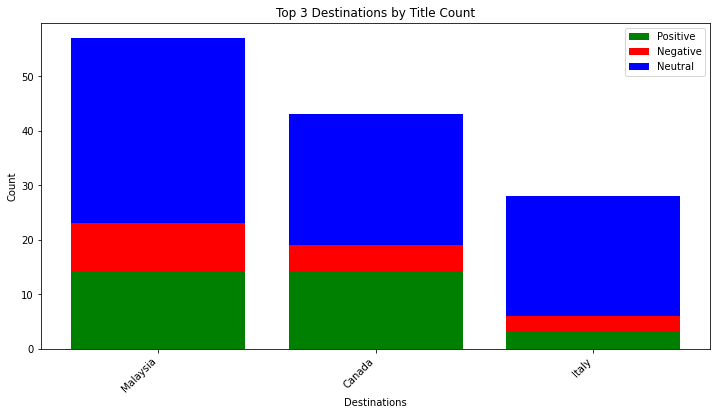

In [69]:
N = 3

# Sort the sentiment_counts_df by title_count in descending order and select the top N countries
top_countries = sentiment_counts_df.orderBy('title_count', ascending=False).limit(N)

# Convert the top_countries DataFrame to a Pandas DataFrame
top_countries_pd = top_countries.toPandas()

# Plot the sentiment counts for each country
plt.figure(figsize=(12, 6))
plt.bar(top_countries_pd['destination'], top_countries_pd['positive'], color='green', label='Positive')
plt.bar(top_countries_pd['destination'], top_countries_pd['negative'], color='red', label='Negative', bottom=top_countries_pd['positive'])
plt.bar(top_countries_pd['destination'], top_countries_pd['neutral'], color='blue', label='Neutral', bottom=top_countries_pd['positive']+top_countries_pd['negative'])
plt.xlabel('Destinations')
plt.ylabel('Count')
plt.title(f'Top {N} Destinations by Title Count')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

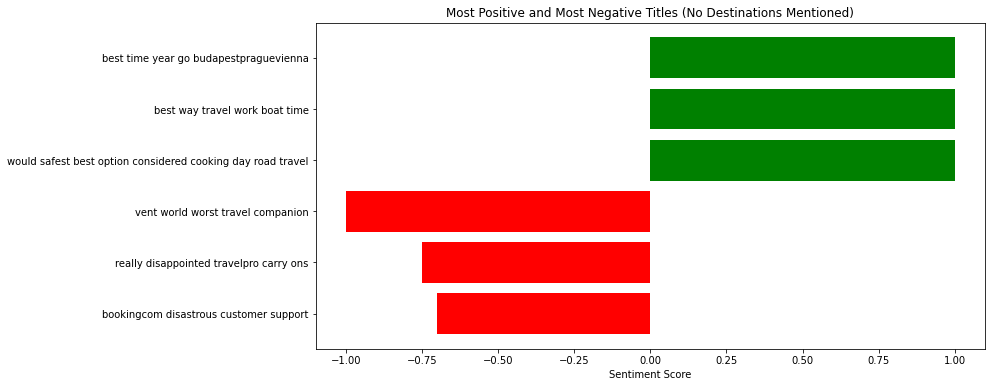

In [70]:
# N titles for most positive and most negative
N = 3

# Filter out titles that have destinations mentioned in them
filtered_titles = sentiment_df.filter(sentiment_df['destinations'].isNull() | (F.size(sentiment_df['destinations']) == 0))

# Get the most positive titles
most_positive_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=False) \
                                      .limit(N)

# Get the most negative titles
most_negative_titles = filtered_titles.select('preprocessed_title', 'title_sentiment') \
                                      .orderBy('title_sentiment', ascending=True) \
                                      .limit(N)

# Concatenate the two DataFrames
top_titles = most_positive_titles.unionByName(most_negative_titles)

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
top_titles_pd = top_titles.toPandas()

# Plot the sentiment scores for the top titles
plt.figure(figsize=(12, 6))
plt.barh(range(2*N), top_titles_pd['title_sentiment'], color=['green']*N + ['red']*N)
plt.yticks(range(2*N), top_titles_pd['preprocessed_title'])
plt.xlabel('Sentiment Score')
plt.title('Most Positive and Most Negative Titles (No Destinations Mentioned)')
plt.gca().invert_yaxis()  # Reverse the order of the y-axis
plt.show()

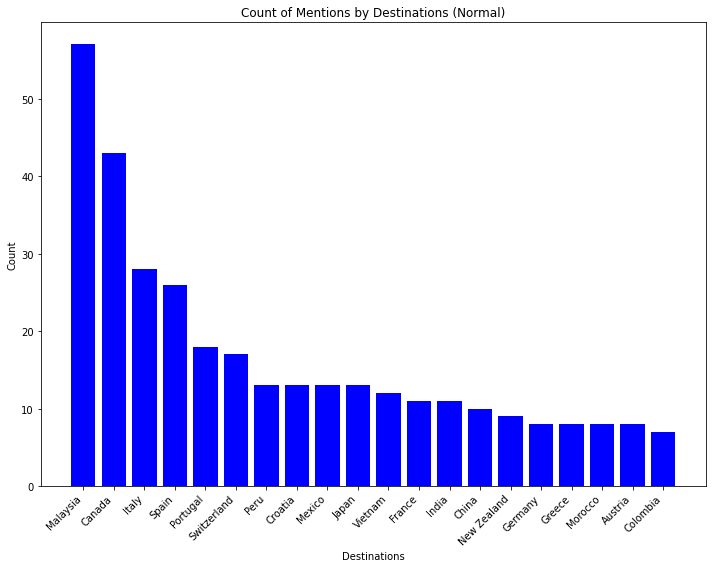

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# First, convert the Spark DataFrame to a Pandas DataFrame
# Ensure that your Spark environment has been configured to allow this conversion
top20_normal_countries = country_normal_counts.orderBy(col("count").desc()).limit(20)
pandas_df = top20_normal_countries.toPandas()

# Now, plotting the data using matplotlib
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
plt.bar(pandas_df['destination'], pandas_df['count'], color='blue')  # Create a bar chart
plt.xlabel('Destinations')  # Label on X-axis
plt.ylabel('Count')  # Label on Y-axis
plt.title('Count of Mentions by Destinations (Normal)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization and Analysis

NER TOP Keywords and word cloud

In [72]:
def generate_top_keywords_NER(df, column_name, top_n):
    # Explode the tokens in the column into separate rows
    exploded_NER_df = NER_df.withColumn("destination", explode("destinations"))
    
    # Filter out any empty or null tokens
    filtered_NER_df = exploded_NER_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))
    
    # Group by token and count the occurrences of each token
    country_NER_counts = filtered_NER_df.groupBy("destination").count().orderBy("count", ascending=False)

    # Sort by count in descending order and select the top n tokens
    top_token_counts = country_NER_counts.limit(top_n)
    
    # Collect the results into a list and return it
    top_tokens = [row['destination'] for row in top_token_counts.collect()]
    return top_tokens

# get top 20 keywords
top20_NER_countries = generate_top_keywords_NER(original_df, 'destination', 20)
print(top20_NER_countries)

['malaysia', 'canada', 'spain', 'italy', 'switzerland', 'portugal', 'japan', 'paris', 'rome', 'vietnam', 'peru', 'china', 'new zealand', 'taiwan', 'scotland', 'france', 'mexico', 'morocco', 'colombia', 'indonesia']


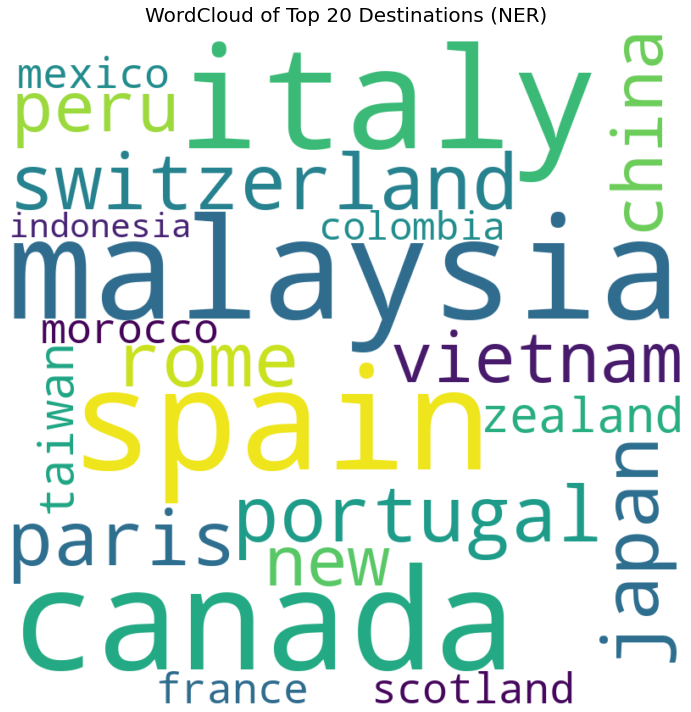

In [73]:
# Create a WordCloud object without a font file
wordcloud = WordCloud(width=800, height=800, background_color='white', ).generate(" ".join(top20_NER_countries))

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Add the word cloud to the axis
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# Customize the appearance
ax.set_title("WordCloud of Top 20 Destinations (NER)", fontsize=20)
plt.tight_layout()

# Display the plot
plt.show()

GEO TOP Keywords and word cloud

In [ ]:
def generate_top_keywords_GEO(df, column_name, top_n):
    # Explode the tokens in the column into separate rows
    exploded_GEO_df = GEO_df.withColumn("destination", explode("destinations"))
    
    # Filter out any empty or null tokens
    filtered_GEO_df = exploded_GEO_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))
    
    # Group by token and count the occurrences of each token
    country_GEO_counts = filtered_GEO_df.groupBy("destination").count().orderBy("count", ascending=False)

    # Sort by count in descending order and select the top n tokens
    top_token_counts = country_GEO_counts.limit(top_n)
    
    # Collect the results into a list and return it
    top_tokens = [row['destination'] for row in top_token_counts.collect()]
    return top_tokens

# get top 20 keywords
top20_GEO_countries = generate_top_keywords_GEO(original_df, 'destination', 20)
print(top20_GEO_countries)

In [ ]:
# Create a WordCloud object without a font file
wordcloud = WordCloud(width=800, height=800, background_color='white', ).generate(" ".join(top20_GEO_countries))

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Add the word cloud to the axis
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# Customize the appearance
ax.set_title("WordCloud of Top 20 Destinations (GEO)", fontsize=20)
plt.tight_layout()

# Display the plot
plt.show()

PyCountry TOP Keywords and word cloud

In [74]:
def generate_top_keywords_pycountry(df, column_name, top_n):
    # Explode the tokens in the column into separate rows
    exploded_pycountry_df = pycountry_df.withColumn("destination", explode("destinations"))
    
    # Filter out any empty or null tokens
    filtered_pycountry_df = exploded_pycountry_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))
    
    # Group by token and count the occurrences of each token
    country_pycountry_counts = filtered_pycountry_df.groupBy("destination").count().orderBy("count", ascending=False)

    # Sort by count in descending order and select the top n tokens
    top_token_counts = country_pycountry_counts.limit(top_n)
    
    # Collect the results into a list and return it
    top_tokens = [row['destination'] for row in top_token_counts.collect()]
    return top_tokens

# get top 20 keywords
top20_pycountry_countries = generate_top_keywords_pycountry(original_df, 'destination', 20)
print(top20_pycountry_countries)

['Malaysia', 'Canada', 'Italy', 'Spain', 'Portugal', 'Switzerland', 'Peru', 'Croatia', 'Mexico', 'Japan', 'France', 'India', 'China', 'New Zealand', 'Germany', 'Greece', 'Morocco', 'Austria', 'Colombia', 'Ireland']


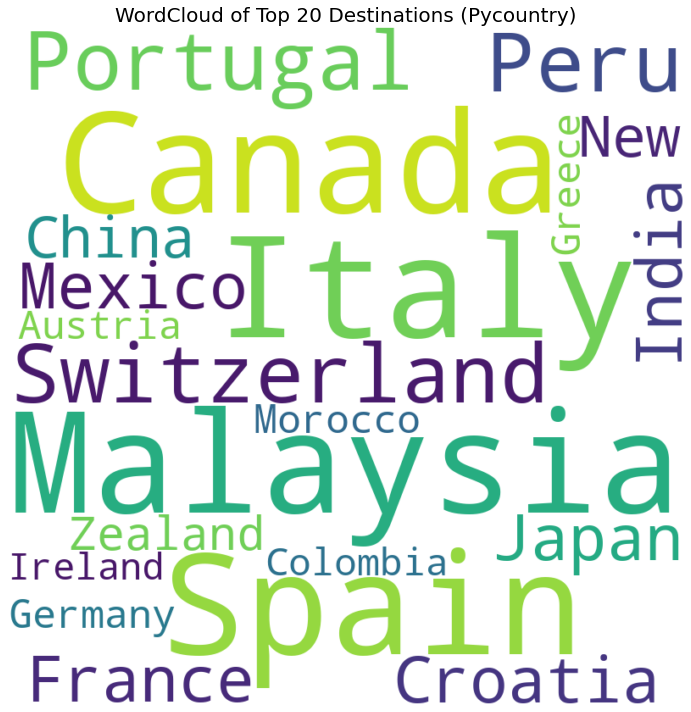

In [75]:
# Create a WordCloud object without a font file
wordcloud = WordCloud(width=800, height=800, background_color='white', ).generate(" ".join(top20_pycountry_countries))

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Add the word cloud to the axis
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# Customize the appearance
ax.set_title("WordCloud of Top 20 Destinations (Pycountry)", fontsize=20)
plt.tight_layout()

# Display the plot
plt.show()

Normal TOP Keywords and word cloud

In [76]:
def generate_top_keywords_normal(df, column_name, top_n):
    # Explode the tokens in the column into separate rows
    exploded_normal_df = normal_df.withColumn("destination", explode("destinations"))
    
    # Filter out any empty or null tokens
    filtered_normal_df = exploded_normal_df.filter((col("destination").isNotNull()) & (size("destinations") > 0))
    
    # Group by token and count the occurrences of each token
    country_normal_counts = filtered_normal_df.groupBy("destination").count().orderBy("count", ascending=False)

    # Sort by count in descending order and select the top n tokens
    top_token_counts = country_normal_counts.limit(top_n)
    
    # Collect the results into a list and return it
    top_tokens = [row['destination'] for row in top_token_counts.collect()]
    return top_tokens

# get top 20 keywords
top20_normal_countries = generate_top_keywords_normal(original_df, 'destination', 20)
print(top20_normal_countries)

['Malaysia', 'Canada', 'Italy', 'Spain', 'Portugal', 'Switzerland', 'Peru', 'Croatia', 'Mexico', 'Japan', 'Vietnam', 'France', 'India', 'China', 'New Zealand', 'Germany', 'Greece', 'Morocco', 'Austria', 'Colombia']


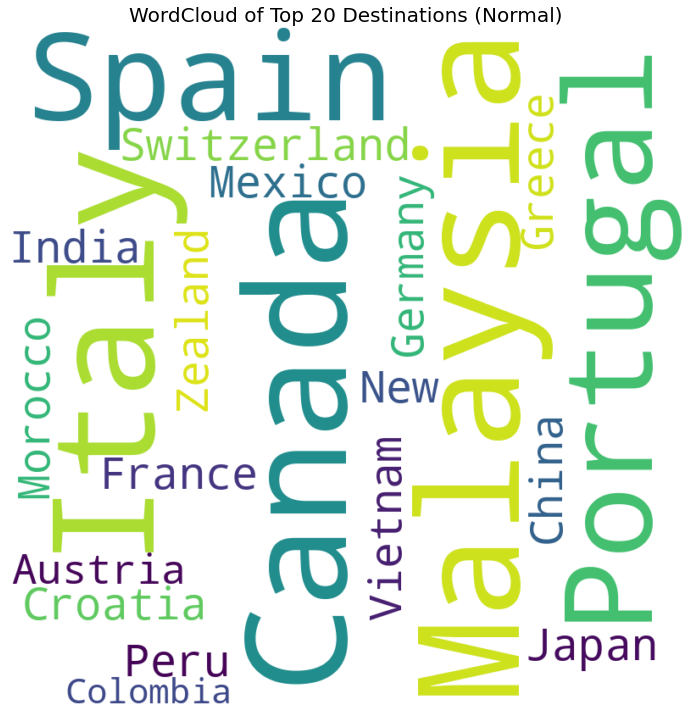

In [77]:
# Create a WordCloud object without a font file
wordcloud = WordCloud(width=800, height=800, background_color='white', ).generate(" ".join(top20_normal_countries))

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Add the word cloud to the axis
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# Customize the appearance
ax.set_title("WordCloud of Top 20 Destinations (Normal)", fontsize=20)
plt.tight_layout()

# Display the plot
plt.show()